In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

## Torchvision module contains different utilities, classes, models and datasets used for computer vision applications
from torchvision import datasets
from torchvision import transforms

## Functional module contains helper functions
import torch.nn.functional as F

In [2]:
# DataLoaders

## Mean and standard deviation of all the pixels in the MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((mean_gray,), (stddev_gray,))])

mnist_train = datasets.MNIST('./data', train = True, download = True, transform = transform)
mnist_valid = datasets.MNIST('./data', train = False, download = True, transform = transform)

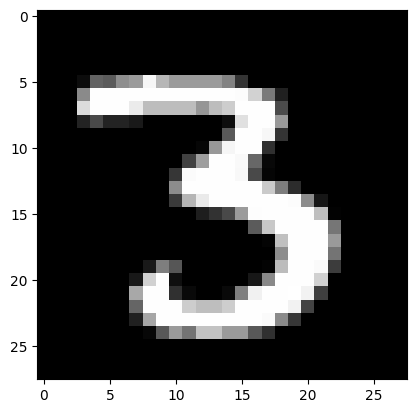

In [3]:
img = mnist_train[12][0].numpy() * stddev_gray + mean_gray

plt.imshow(img.reshape(28,28), cmap = 'gray')

In [4]:
label = mnist_train[12][1]
label

3

In [5]:
batch_size = 1024

In [6]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

In [7]:
# TIME TO CREATE THE MODEL:

class MNISTNet(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        # which is what we are using.
        
        # Convolution Layer 1                             # 28 x 28 x 1  (input)
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)     # 20 x 20 x 30  (after 2nd convolution)
        self.conv2_drop = nn.Dropout2d(p=0.5)             # Same as above
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 30  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(3000, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 3000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

In [8]:
# Create objects

net = MNISTNet()

if cuda.is_available():
    net = net.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [10]:
# Training Model:

num_epochs = 100

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    valid_accuracy.append(correct / len(mnist_valid_loader.dataset) * 100.0)

    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/100, Tr Loss: 0.3327, Tr Acc: 90.1900, Val Loss: 0.2114, Val Acc: 93.6200
Epoch 2/100, Tr Loss: 0.2418, Tr Acc: 92.8750, Val Loss: 0.1590, Val Acc: 95.2700
Epoch 3/100, Tr Loss: 0.1923, Tr Acc: 94.3083, Val Loss: 0.1270, Val Acc: 96.2200
Epoch 4/100, Tr Loss: 0.1664, Tr Acc: 95.0250, Val Loss: 0.1137, Val Acc: 96.5600
Epoch 5/100, Tr Loss: 0.1467, Tr Acc: 95.6217, Val Loss: 0.1022, Val Acc: 96.8500
Epoch 6/100, Tr Loss: 0.1333, Tr Acc: 96.1250, Val Loss: 0.0934, Val Acc: 97.1500
Epoch 7/100, Tr Loss: 0.1212, Tr Acc: 96.4133, Val Loss: 0.0832, Val Acc: 97.2300
Epoch 8/100, Tr Loss: 0.1115, Tr Acc: 96.6683, Val Loss: 0.0768, Val Acc: 97.6000
Epoch 9/100, Tr Loss: 0.1023, Tr Acc: 96.9117, Val Loss: 0.0703, Val Acc: 97.7900
Epoch 10/100, Tr Loss: 0.0969, Tr Acc: 97.0767, Val Loss: 0.0634, Val Acc: 97.9100
Epoch 11/100, Tr Loss: 0.0914, Tr Acc: 97.2617, Val Loss: 0.0668, Val Acc: 97.8400
Epoch 12/100, Tr Loss: 0.0863, Tr Acc: 97.3817, Val Loss: 0.0633, Val Acc: 98.0700
Epoch 13/100,

In [13]:
torch.save(net.state_dict(), './3.model.pth')

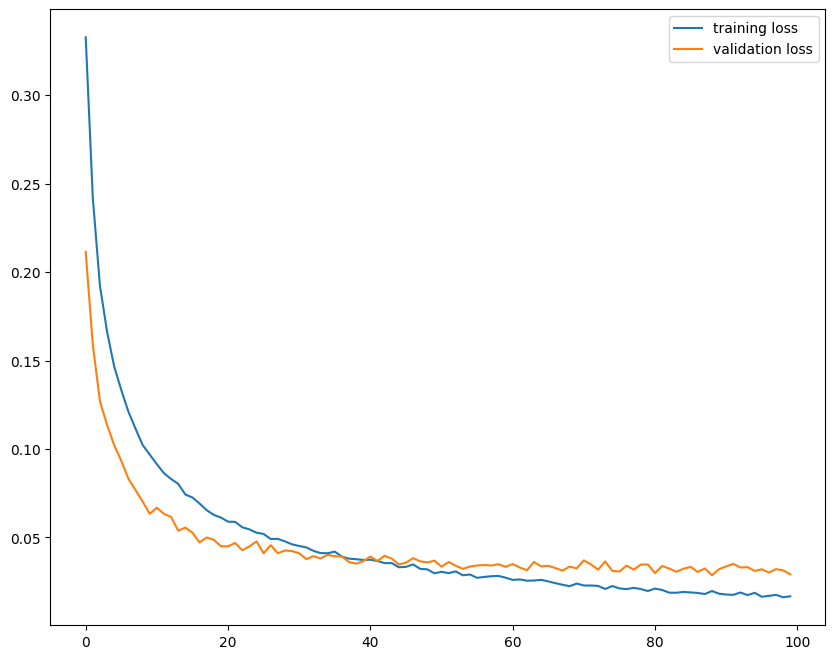

In [14]:
f = plt.figure(figsize=(10,8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

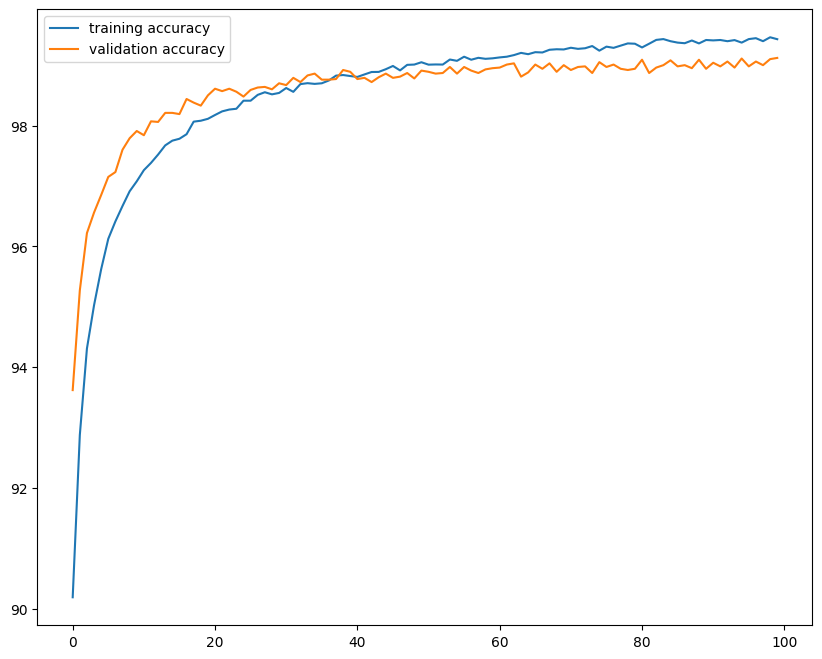

"\nf = plt.figure(figsize=(10,8))\nplt.plot(train_accuracy, label='training accuracy')\nplt.plot(valid_accuracy, label='validation accuracy')\nplt.legend()\nplt.show()\n"

In [17]:
# Convert train_accuracy and valid_accuracy to CPU and then to Python floats, if necessary
train_accuracy_cpu = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in train_accuracy]
valid_accuracy_cpu = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in valid_accuracy]

f = plt.figure(figsize=(10,8))
plt.plot(train_accuracy_cpu, label='training accuracy')
plt.plot(valid_accuracy_cpu, label='validation accuracy')
plt.legend()
plt.show()

'''
f = plt.figure(figsize=(10,8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()
'''

In [26]:
# standalone inference

image_index = 23
img = mnist_valid[image_index][0].resize_((1,1,28,28))
img = Variable(img)
label = mnist_valid[image_index][1]

net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()

output = net(img)

output.data

tensor([[ -7.7563, -10.8912, -14.0310,  -0.9022,  -7.6347,  34.9648,  14.0937,
         -13.1840,   1.0224,  15.3319]], device='cuda:0')

In [27]:
_, predicted = torch.max(output.data, 1)
print('Prediction is: ', predicted)
print('Actual     is: ')

Prediction is:  tensor([5], device='cuda:0')
Actual     is: 


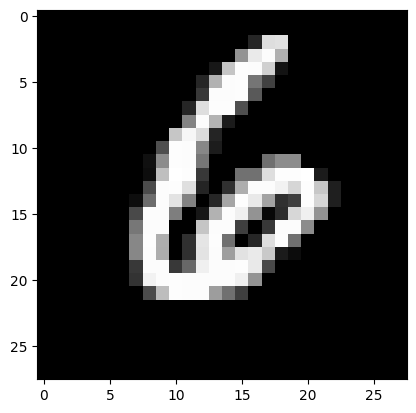

In [28]:
img = mnist_train[13][0].numpy() * stddev_gray + mean_gray

plt.imshow(img.reshape(28,28), cmap = 'gray')